## Extract and Remove Value/Unit from catalog_content
This cell extracts the Value and Unit from the end of `catalog_content`, creates two new columns, and then strips these details from the original text.

# Import Libraries and Create Directories

In [230]:
# Install PyTorch if not already installed
# paste this in terminal:
# pip3 install torch torchvision --index-url https://download.pytorch.org/whl/cu126
# !pip install scikit-learn
# !pip install pandas numpy matplotlib jupyterlab ipywidgets
# !pip install xgboost

In [1]:
import os
import pandas as pd
import numpy as np
from IPython import display
from urllib.parse import urlparse, unquote
import re
import torch
from pathlib import Path
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', None)

In [2]:
# projects_dir_path = os.path.join(os.getcwd(), "projects")
# # os.makedirs(projects_dir_path, exist_ok=True)
# price_predict_project_path = os.path.join(projects_dir_path, "price_predict")
# os.makedirs(price_predict_project_path, exist_ok=True)
# os.chdir(price_predict_project_path)

move the csv files into the 'dataset' directory after creating it

In [3]:
# put your own directory path where the dataset is located
os.chdir(r'C:\Users\alvin\Desktop\projects\price_predict\dataset')

In [4]:
# check if the directories are created successfully
os.listdir()

['images',
 'product_with_new_features.csv',
 'sample_test.csv',
 'sample_test_out.csv',
 'test.csv',
 'train.csv']

In [5]:
# load the training data
train_df = pd.read_csv("train.csv")
train_df.sample(1)

,sample_id,catalog_content,image_link,price
34323,140867,Item Name: Full Size Milk Chocolate Mars Singles in Box of 40\nProduct Description: Full Size Milk Chocolate Mars Singles in Box of 40\nValue: 78.56\nUnit: Ounce\n,https://m.media-amazon.com/images/I/313HeMt23qL.jpg,58.95


# Check data quality

In [6]:
# Check for missing values
train_df.isnull().sum()

sample_id          0
catalog_content    0
image_link         0
price              0
dtype: int64

In [7]:
# Remove 'Item Name: ' prefix from catalog_content
def remove_item_name_prefix(text):
    return text.strip().replace('Item Name:', '').strip()

extracted_df = train_df.copy()
extracted_df['catalog_content'] = extracted_df['catalog_content'].apply(remove_item_name_prefix)
extracted_df.sample(1)

,sample_id,catalog_content,image_link,price
8877,166686,"Corona, Traditional Chocolate, Tablets, 17.6 Ounces per Pack, Pack of 3\nBullet Point 1: TRADITIONAL CHOCOLATE CORONA: Classic, rich flavor that brings the joy of authentic table chocolate to every cup.\nBullet Point 2: PREMIUM QUALITY: Made with 100% real cocoa, free from trans fats and cholesterol.\nBullet Point 3: QUICK AND EASY: Just one tablet makes a cup! Dissolve it in milk or water over low heat, stir and enjoy.\nBullet Point 4: SHARE WITH FRIENDS AND FAMILY: Perfect for group gatherings or cozy moments at home.\nBullet Point 5: LARGE SERVINGS: With three packs, you get a total of 60 servings, so everyone can have a cup!\nProduct Description: This traditional table chocolate is perfect whether you’re enjoying it solo or sharing it with loved ones. It’s quick and easy to prepare, making it a great companion for breakfasts, dinners, or even snack breaks when you need a little energy boost. Whether you prefer it with water, cow’s milk, or plant-based alternatives, it’s versatile and suited for all tastes. While it’s most commonly enjoyed hot—especially on chilly days—you can also have it cold by adding ice. Blend it up or keep the ice whole—either way, it’s always a treat!\nValue: 52.8\nUnit: Ounce",https://m.media-amazon.com/images/I/81UJaTiajDL.jpg,16.42


Every single record comes with values and units except for one, do a bit of Feature Engineering

In [8]:
# Extract "Value" and "Unit" from catalog_content into two new columns, then remove them from catalog_content
def extract_value_unit_and_strip(text):
    match = re.search(r'Value:\s*([^\n]+)\s*Unit:\s*([^\n]+)', text)
    if match:
        value = match.group(1).strip()
        unit = match.group(2).strip()
        # Remove the matched part from the text
        stripped = re.sub(r'Value:\s*[^\n]+\s*Unit:\s*[^\n]+', '', text).strip()
        return pd.Series([value, unit, stripped])
    else:
        return pd.Series([None, None, text])


extracted_df[['value', 'unit', 'catalog_content']] = extracted_df['catalog_content'].apply(extract_value_unit_and_strip)

In [9]:
extracted_df.sample(1)

,sample_id,catalog_content,image_link,price,value,unit
71940,275174,"Minor's Original Formula Beef Base, 16 ounce\nBullet Point 1: Consistent flavor every time\nBullet Point 2: Zero grams Trans Fat and Saturated Fat per serving\nBullet Point 3: No preservatives and no artificial flavors\nBullet Point 4: Premium quality and flavor\nBullet Point 5: Every batch is sensory tested prior to being released for shipment\nProduct Description: Seasoned paste concentrate made from freshly roasted lean primal cuts of USDA inspected beef which delivers the savory flavor of freshly roasted beef and natural beef juices.",https://m.media-amazon.com/images/I/41aGwF5vrrL.jpg,18.3,16.0,Ounce


In [10]:
# number of records share everything the same except for price
extracted_df[['catalog_content', 'image_link', 'value', 'unit']].duplicated().sum()

np.int64(46)

Some records share the same images, even though they are the same product, they have different quantities

In [11]:
# Get the columns we want to check
cols_to_check = ['catalog_content', 'image_link', 'value', 'unit']
# Create boolean mask of duplicated rows
duplicated_mask = extracted_df[cols_to_check].duplicated(keep=False)
# Filter the dataframe using the mask
dup_df = extracted_df[duplicated_mask].sort_values(by='image_link')
dup_df.sample(1)

,sample_id,catalog_content,image_link,price,value,unit
49839,134512,"McCormick Golden Dipt Cajun Seafood Fry Mix, 10 oz (Pack of 8)\nBullet Point 1: Fish Fry with corn and wheat flours and spiced with garlic, paprika and onion\nBullet Point 2: Batter mix coats up to 6 pounds of food for a golden crunch\nBullet Point 3: 3 easy steps to seal in natural juices: combine with water, dredge fish, and fry\nBullet Point 4: Adds a touch of heat to battered catfish, tilapia, flounder, trout and shrimp\nBullet Point 5: Dredge fish in milk and eggs first for a hearty taste and thicker coating",https://m.media-amazon.com/images/I/81abckfUvFL.jpg,6.99,80.0,Ounce


In [12]:
# Group by catalog_content and image_link, then aggregate
cleaned_df = extracted_df.groupby(cols_to_check).agg({
    'sample_id': 'min',  # keep lowest sample_id
    'price': 'mean'      # take average of prices
}).reset_index()

# Show the first few rows to verify
# cleaned_df.sample(5)

# Print the reduction in records
print(f"Original records: {len(cleaned_df)}")
print(f"After deduplication: {len(cleaned_df)}")

Original records: 74953
After deduplication: 74953


# Download and Handle Images

In [16]:
images = train_df['image_link']
images.sample(5)

4523     https://m.media-amazon.com/images/I/81JaNey0-bL.jpg
38684    https://m.media-amazon.com/images/I/81c97ZKB11L.jpg
47421    https://m.media-amazon.com/images/I/8126oGRQBkL.jpg
17532    https://m.media-amazon.com/images/I/71uLysZ-0rL.jpg
13514    https://m.media-amazon.com/images/I/71wqZB-G6PL.jpg
Name: image_link, dtype: object

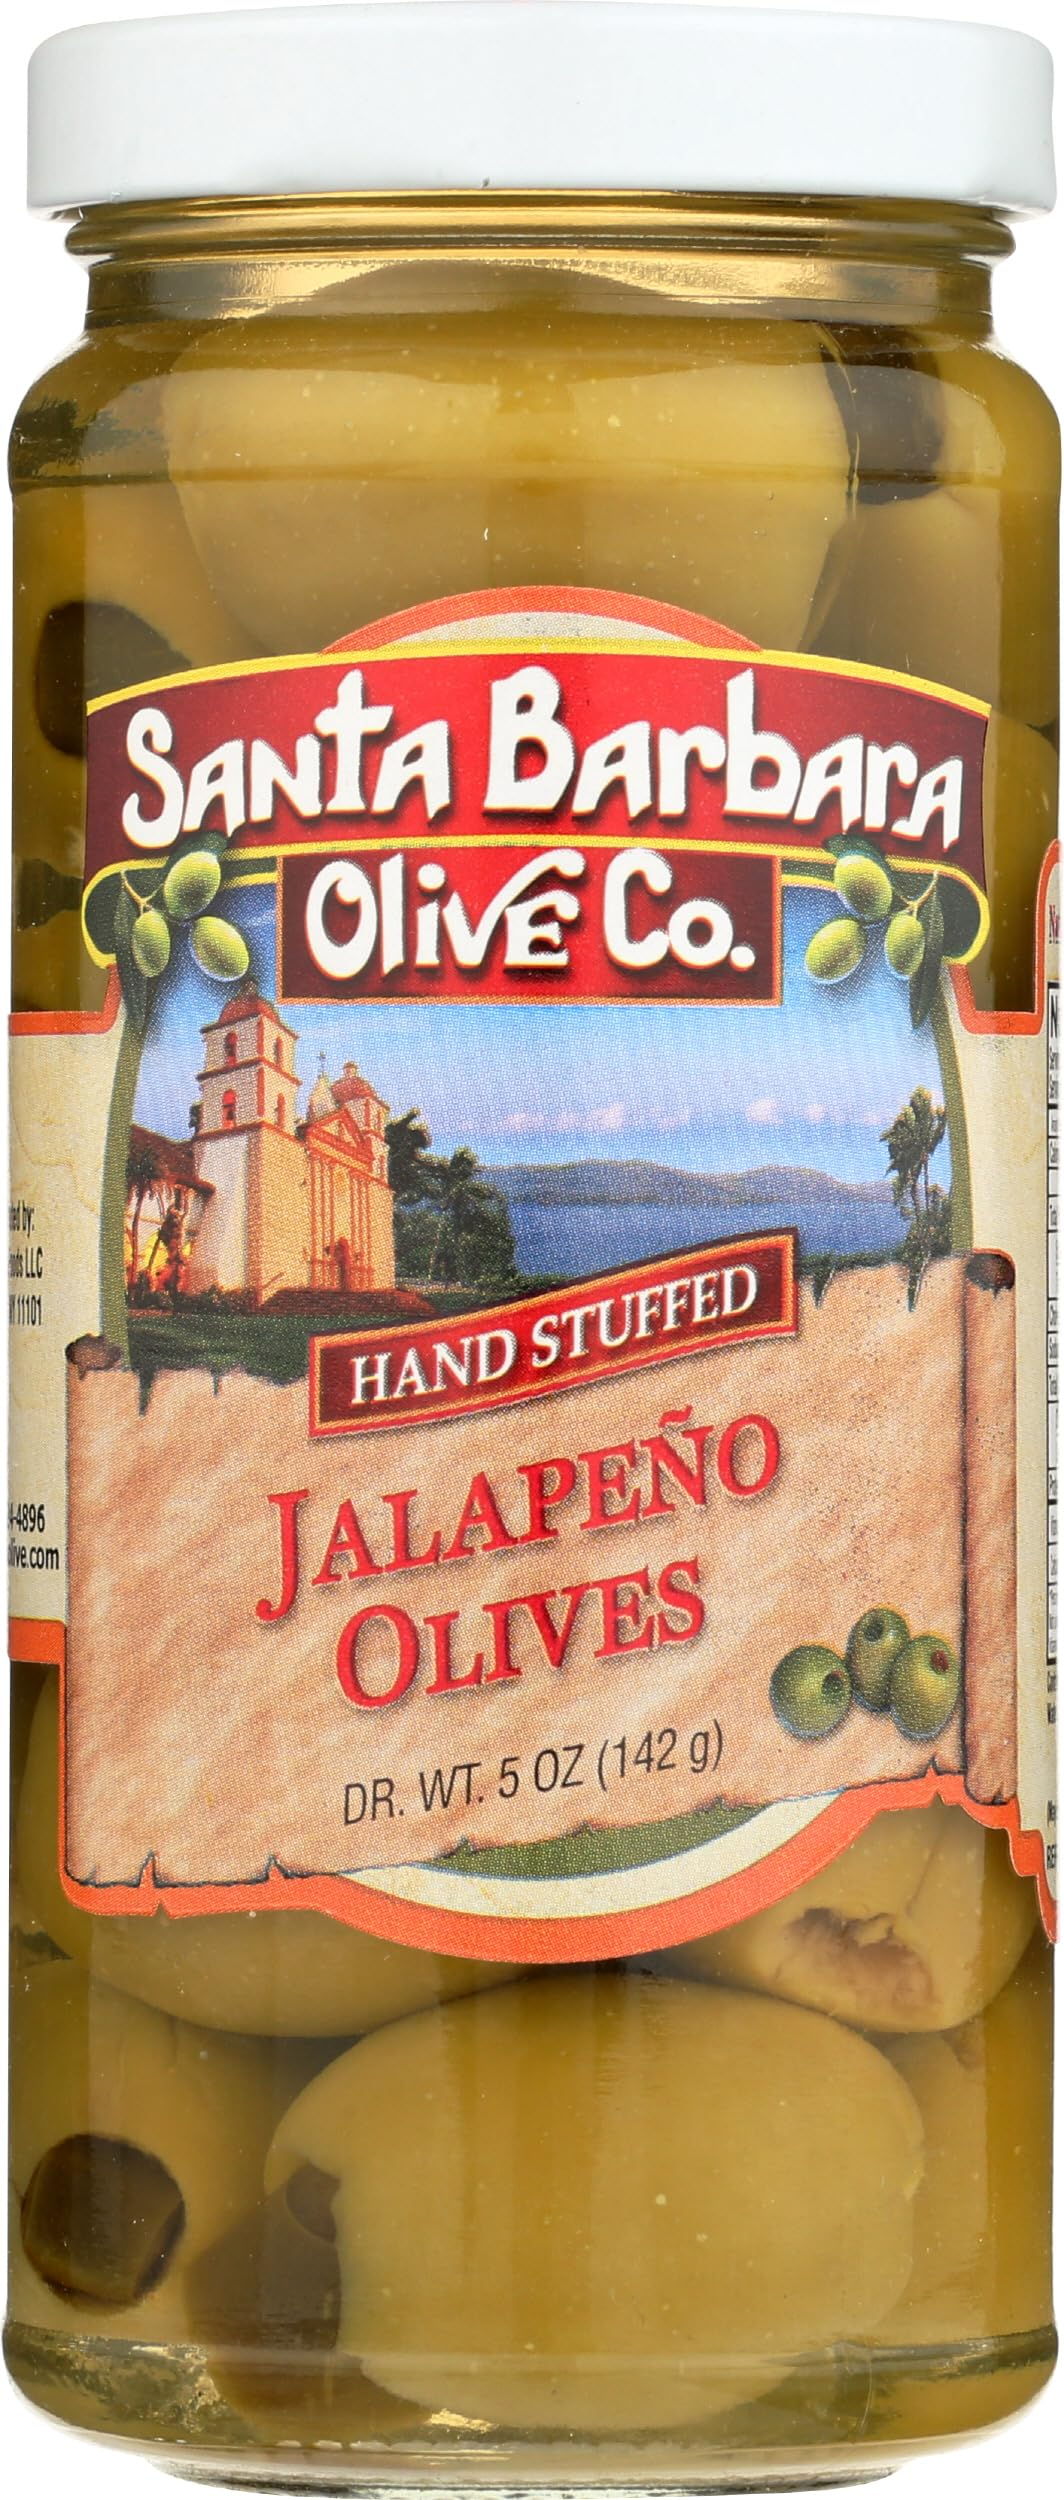

In [17]:
# Get a single image URL
test_image = images.sample(1).iloc[0] # use iloc because sample returns a Series
# test_image = images.sample(1)
display.Image(test_image, width=300, height=200)
# display.Image()

In [18]:
print(test_image)

https://m.media-amazon.com/images/I/81SYpXmHIoL.jpg


## Downloading Images

In [19]:
# # functions provided by Kaggle to download images
# import re
# import os
# import pandas as pd
# import multiprocessing
# from time import time as timer
# from tqdm import tqdm
# import numpy as np
# from pathlib import Path
# from functools import partial
# import requests
# import urllib
# # download single image
# def download_image(image_link, savefolder):
#     if(isinstance(image_link, str)):
#         filename = Path(image_link).name
#         image_save_path = os.path.join(savefolder, filename)
#         if(not os.path.exists(image_save_path)):
#             try:
#                 urllib.request.urlretrieve(image_link, image_save_path)    
#             except Exception as ex:
#                 print('Warning: Not able to download - {}\n{}'.format(image_link, ex))
#         else:
#             return
#     return
# # download multiple images in parallel
# def download_images(image_links, download_folder):
#     if not os.path.exists(download_folder):
#         os.makedirs(download_folder)
#     results = []
#     download_image_partial = partial(download_image, savefolder=download_folder)
#     with multiprocessing.Pool(50) as pool:
#         for result in tqdm(pool.imap(download_image_partial, image_links), total=len(image_links)):
#             results.append(result)
#         pool.close()
#         pool.join()

# Finalize the Dataset

In [20]:
os.listdir()

['images',
 'product_with_new_features.csv',
 'sample_test.csv',
 'sample_test_out.csv',
 'test.csv',
 'train.csv']

In [21]:
# Multi-threading is somehow not working for my machine, downloading images one by one. Try the download_images function first and see if it works
# for image in images:
#     download_image(image, images_dir_path)

In [22]:
# number of images that are unable to be downloaded
len(images) - len(os.listdir("images"))

25604

In [23]:
# match records with corresponding image paths
IM_DIR = Path("images")
all_paths = [p for p in IM_DIR.rglob("*")]
by_last15_fname = {}
by_last15_stem  = {}

for p in all_paths:
    fname = p.name.lower()           # e.g., abc...xyz.jpg
    stem  = p.stem.lower()           # abc...xyz
    by_last15_fname[fname[-15:]] = p
    by_last15_stem[stem[-15:]]   = p


def url_keys(url: str):
    base = Path(unquote(urlparse(url).path)).name.lower()
    return base[-15:], Path(base).stem.lower()[-15:]

def match_existing_path(url: str):
    last15_fname, last15_stem = url_keys(url)
    return (
        by_last15_fname.get(last15_fname)
        or by_last15_stem.get(last15_stem)
    )

cleaned_df["file_path_obj"] = cleaned_df["image_link"].map(match_existing_path)
cleaned_df["image_path"] = cleaned_df["file_path_obj"].map(lambda p: str(p) if p else None)

In [24]:
cleaned_df.sample(1)

,catalog_content,image_link,value,unit,sample_id,price,file_path_obj,image_path
10640,"Café Escapes Café Caramel K-Cup Pack\nBullet Point 1: Buttery rich\nBullet Point 2: Silky smooth\nBullet Point 3: Captivatingly caramelicious\nProduct Description: Make those special ""me"" moments even more delectable with an enticingly light cup of Café Caramel. Each blissfully buttery sip is a reminder-life really does taste better with caramel on top. <p> INGREDIENTS: Sugar, Creamer (hydrogenated coconut oil, glucose syrup, sodium caseinate (from milk), sodium polyphosphate, dipotassium phosphate, sodium stearoyl-2-lactylate, silicon dioxide), Nonfat milk, Caramel Color, Instant Coffee, Modified Food Starch, Salt, Natural and Artifical Flavor, Sucralose. <p> Contains: Milk",https://m.media-amazon.com/images/I/41rrg+Aa7yL.jpg,96.0,Count,254541,19.28,None,None


In [25]:
# number of available images for training samples
available_count = cleaned_df["image_path"].notnull().sum()
available_count

np.int64(51852)

In [26]:
finalized_df = cleaned_df.drop(columns=["image_link", "file_path_obj"])[cleaned_df['file_path_obj'].notnull()][['sample_id', 'catalog_content', 'image_path', 'value', 'unit', 'price']]
finalized_df.reset_index(drop=True, inplace=True)
finalized_df.sample(1)

,sample_id,catalog_content,image_path,value,unit,price
16050,44986,"Foods Alive Organic 100% Hemp Oil Artisan Cold-Pressed - 8 fl oz\nBullet Point 1: Go Beyond Organic! Hemp Oil is considered to be one of the most nutritious of all plant oils and contains Super Omega-3 (SDA) and Super Omega-6 (GLA) But, not all hemp oil is created equally\nBullet Point 2: Foods Alive",images\61axz2pXnKL.jpg,8.0,Fl Oz,10.29


In [27]:
finalized_df.shape

(51852, 6)

In [28]:
# Take care of missing values in 'value' and 'unit' columns
# ===== Minimal, no-frills cleaning (run once before training) =====
df = finalized_df.copy()

# price: numeric, drop non-finite, clamp to >= 0 for log1p
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df = df[np.isfinite(df["price"])]
df["price"] = df["price"].clip(lower=0)

# value: numeric; NaNs will be imputed with TRAIN median *after* the split
if "value" in df.columns:
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

# unit: replace None/NaN with "<UNK>" so categoricals are safe
if "unit" in df.columns:
    df["unit"] = df["unit"].astype("string").fillna("<UNK>")

# ---- split (same as before) ----
def split_3way(d, train_frac=0.70, val_frac=0.15, seed=42):
    d_ = d.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    n=len(d_); n_tr=int(n*train_frac); n_va=int(n*val_frac)
    return d_.iloc[:n_tr].copy(), d_.iloc[n_tr:n_tr+n_va].copy(), d_.iloc[n_tr+n_va:].copy()

df_tr, df_va, df_te = split_3way(df, 0.70, 0.15, seed=42)

# value median from TRAIN only → apply to all splits
if "value" in df_tr.columns:
    med = df_tr["value"].median(skipna=True)
    df_tr["value"] = df_tr["value"].fillna(med)
    df_va["value"] = df_va["value"].fillna(med)
    df_te["value"] = df_te["value"].fillna(med)

print(
    "NaN counts after clean:",
    {"price": [df_tr["price"].isna().sum(), df_va["price"].isna().sum(), df_te["price"].isna().sum()],
     "value": ([df_tr["value"].isna().sum(), df_va["value"].isna().sum(), df_te["value"].isna().sum()] if "value" in df.columns else "n/a"),
     "unit":  ([df_tr["unit"].isna().sum(),  df_va["unit"].isna().sum(),  df_te["unit"].isna().sum()]  if "unit"  in df.columns else "n/a")}
)


NaN counts after clean: {'price': [np.int64(0), np.int64(0), np.int64(0)], 'value': [np.int64(0), np.int64(0), np.int64(0)], 'unit': [np.int64(0), np.int64(0), np.int64(0)]}


In [29]:
df.sample(1)

,sample_id,catalog_content,image_path,value,unit,price
15349,31162,"Food to Live - Cannellini Beans, 3 Pounds Dried White Kidney Beans, Sproutable, Vegan, Kosher, Sirtfood, Bulk. Rich in Fiber, Protein. Great for Minestrone Soup, Bean Salad, Stews, White Chili.\nBullet Point 1: ✔️High in protein and fiber and low in fat\nBullet Point 2: ✔️Popular in Tuscan and other Italian cuisine\nBullet Point 3: ✔️Basic ingredient of minestrone\nProduct Description: Cannellini beans are very popular in many types of Italian cuisine. A staple of minestrones, fagioli's, and salads, dried cannelleni beans make a gourmet addition to any pantry. Their low cost, long shelf life, and gastronomic versatility make dried cannelleni beans indispensable in any gourmet kitchen. These gourmet beans double in size when soaked, so a few beans go a long way in a dish. Join an elite group of culinary experts, grab some cannellini and call yourself a ""bean eater"" today!",images\81l4KaIHS9L.jpg,48.0,Ounce,22.99


In [30]:
# standardize the 'unit' column
# ===== Unit string standardization (no numeric conversion) =====
import re
import pandas as pd

df_std_units = df.copy()

def clean_text(s: str) -> str:
    s = s.lower()
    # replace punctuation with space, keep letters/numbers/underscore
    s = re.sub(r"[^\w\s]", " ", s)
    # collapse multiple spaces'''
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Canonical mapping AFTER cleaning (keys are already lowercase & de-punctuated)
# Add/edit keys as you discover more variants.
CANON = {
    # count / each
    "count": "count",
    "ct": "count",
    "each": "count",
    "ea": "count",

    # ounce (weight)
    "oz": "ounce",
    "ounce": "ounce",
    "ounces": "ounce",

    # fluid ounce (volume)
    "fl oz": "fluid_ounce",
    "floz": "fluid_ounce",
    "fluid ounce": "fluid_ounce",
    "fluid ounces": "fluid_ounce",

    # pound
    "lb": "pound",
    "lbs": "pound",
    "pound": "pound",
    "pounds": "pound",

    # gram
    "g": "gram",
    "gram": "gram",
    "grams": "gram",
    "gramm": "gram",
    "gr": "gram",

    # kilogram
    "kg": "kilogram",
    "kilogram": "kilogram",
    "kilograms": "kilogram",

    # milliliter / millilitre
    "ml": "milliliter",
    "milliliter": "milliliter",
    "milliliters": "milliliter",
    "millilitre": "milliliter",
    "millilitres": "milliliter",

    # liter / litre
    "l": "liter",
    "liter": "liter",
    "liters": "liter",
    "litre": "liter",
    "litres": "liter",
    "ltr": "liter",

    # bottle(s)
    "bottle": "bottle",
    "bottles": "bottle",
    "per carton": "bottle",

    # bag(s)
    "bag": "bag",
    "bags": "bag",
    "ziplock bags": "bag",
    "ziplock bag": "bag",

    # package/pack
    "pack": "pack",
    "pk": "pack",
    "package": "pack",
    "packages": "pack",
    'paper cupcake liners': 'pack',
    'per package': 'pack',

    # length units (optional)
    "in": "inch",
    "inch": "inch",
    "inches": "inch",

    # generic fallback
    "unit": "count",
    "unità": "count",
    
    # incorrect extractions
    "24": "count",
    'none': '<unk>',
    "7 2 oz": "ounce",
    '1': '<unk>',
}

def normalize_unit(u) -> str:
    if pd.isna(u) or u is None:
        return "<unk>"
    s = clean_text(str(u))
    if not s:
        return "<unk>"

    # First try direct match
    if s in CANON:
        return CANON[s]

    # Phrase heuristics (order matters: more specific first)
    # e.g., "fl oz 12" or "12 fl oz" → fluid_ounce (we only keep the canonical label)
    if "fl oz" in s or "fluid ounce" in s or "floz" in s:
        return "fluid_ounce"

    # plural → singular fallbacks
    if s.endswith("s") and s[:-1] in CANON:
        return CANON[s[:-1]]

    # common near-variants
    if s.replace(" ", "") in CANON:
        return CANON[s.replace(" ", "")]

    # last-resort: if it exactly equals a known base like "ounces" → ounce, "pounds" → pound, etc.
    plurals = {
        "ounces": "ounce", "pounds": "pound", "grams": "gram",
        "liters": "liter", "litres": "liter", "milliliters": "milliliter",
        "bottles": "bottle", "bags": "bag", "packages": "pack"
    }
    if s in plurals:
        return plurals[s]

    # unknown string, keep cleaned token to preserve information
    return s

# Show pre-standardization head
print("Top 20 raw unit values:")
print(df_std_units["unit"].value_counts(dropna=False).head(20))

# Apply normalization (string only; no numeric conversion)
df_std_units["unit_norm"] = df_std_units["unit"].apply(normalize_unit)

print("\nTop 30 normalized unit values:")
print(df_std_units["unit_norm"].value_counts().head(30))

# (Optional) replace original column
df_std_units["unit"] = df_std_units["unit_norm"]

# If you want to see how some specific variants mapped:
SAMPLES = ["Ounce","ounce","ounces","Oz","OZ","Fl Oz","Fl. Oz","fluid Ounce",
           "lb","pound","ct","COUNT","each","bottles","Ziplock bags","in","millilitre"]
probe = pd.Series(SAMPLES, name="sample")
probe_norm = probe.apply(normalize_unit)
print("\nSample normalization:")
print(pd.DataFrame({"raw": probe, "norm": probe_norm}))


Top 20 raw unit values:
unit
Ounce          28253
Count          12128
Fl Oz           7683
ounce           1345
None             659
oz               656
count            539
pound            104
fl oz             98
Oz                53
Pound             30
ct                26
Fluid Ounce       23
FL Oz             21
OZ                19
lb                16
Fl. Oz            16
gram              13
Gram              11
ounces            10
Name: count, dtype: Int64

Top 30 normalized unit values:
unit_norm
ounce             30340
count             12718
fluid_ounce        7870
<unk>               662
pound               154
gram                 33
pack                 16
milliliter           12
bottle                9
bag                   7
kilogram              5
liter                 4
jar                   3
can                   3
k cups                3
piece                 2
tea bags              2
foot                  1
pouch                 1
mililitro             1
pro

In [332]:
df_std_units.unit.value_counts().head(3)

unit
ounce          30340
count          12718
fluid_ounce     7870
Name: count, dtype: int64

In [233]:
finalized_df = df_std_units.copy().drop(columns=['unit_norm'])
finalized_df.catalog_content = finalized_df.catalog_content.str.strip()
finalized_df.sample(1)

,sample_id,catalog_content,image_path,value,unit,price
43047,254184,"SodaStream Orange Syrup, 14.8 Fluid Ounce\nBullet Point 1: Less sugar than store bought drinks\nBullet Point 2: Does not contain high-fructose corn syrup or aspartame\nBullet Point 3: Each bottle makes 7 liters of refreshing soda\nBullet Point 4: Simply carbonate water with your SodaStream machine\nBullet Point 5: Caffeine-free",images\61PuUU458VL.jpg,14.9,ounce,15.99


# Extract more features from description for 

In [ ]:
# import library to call gemini API
# !pip install google-generativeai
import google.generativeai as genai

# API key
API_KEY = None
genai.configure(api_key=API_KEY)

# Initialize the Gemini API with the free tier model
model = genai.GenerativeModel('gemini-2.5-flash-lite')

In [290]:
import time
from tqdm import tqdm  # pip install tqdm if needed

df = finalized_df.copy()

# Prepare descriptions & IDs
descs = df["catalog_content"].fillna("").astype(str).tolist()
ids = df.index.tolist()
records = list(zip(ids, descs))

BATCH_SIZE = 200        # tune for token limits
SLEEP_SECONDS = 40.0    # tune for rate limits

allowed_categories = {
    "Grocery",
    "Snacks",
    "Beverages",
    "Household Supplies",
    "Kitchen & Dining",
    "Home Organization",
    "Furniture",
    "Electronics",
    "Personal Care",
    "Pet Supplies",
    "Baby Products",
    "Office Supplies",
    "Tools & Hardware",
    "Clothing",
    "Other",
}

id_to_category = {}

for batch_idx, start in enumerate(tqdm(range(0, len(records), BATCH_SIZE))):
    batch = records[start:start + BATCH_SIZE]

    # Build "<id>: <description>" lines
    lines = []
    for pid, desc in batch:
        clean_desc = " ".join(desc.split())  # collapse whitespace/newlines
        lines.append(f"{pid}: {clean_desc}")
    items_block = "\n".join(lines)

    prompt = f"""
You are a product categorization assistant for an e-commerce catalog.

You will receive multiple products. Each product is on its own line in the format:
<id>: <description>

Your task:
- For each product, choose exactly one category from the list below that best matches the product.

Categories:
Grocery
Snacks
Beverages
Household Supplies
Kitchen & Dining
Home Organization
Furniture
Electronics
Personal Care
Pet Supplies
Baby Products
Office Supplies
Tools & Hardware
Clothing
Other

Output rules (very important):
- For each input line, output ONE line in the format:
  <id>: <category>
- Use exactly one category name from the list above.
- Do NOT invent new category names.
- Do NOT skip any ids.
- Do NOT add any extra ids.
- Do NOT write explanations or comments.
- Do NOT wrap the result in JSON or any other structure.

Input products:
{items_block}

Now respond ONLY with lines like:
<id>: <category>
"""

    # Call Gemini
    response = model.generate_content(prompt)
    text = response.text.strip()

    # Parse each line: "<id>: <category>"
    for line in text.splitlines():
        line = line.strip()
        if not line:
            continue
        if ":" not in line:
            continue

        left, right = line.split(":", 1)
        left = left.strip()
        right = right.strip()

        # Try to parse id as int
        try:
            pid = int(left)
        except ValueError:
            continue  # skip malformed lines

        cat = right
        if cat not in allowed_categories:
            cat = "Other"

        id_to_category[pid] = cat

    # Throttle to avoid rate limits
    if batch_idx < (len(range(0, len(records), BATCH_SIZE)) - 1):
        time.sleep(SLEEP_SECONDS)

# Build final category column with fallback "Other" for any missing ids
categories = [id_to_category.get(idx, "Other") for idx in df.index]

df["category"] = categories
df["category"] = df["category"].astype("category")

print(df["category"].value_counts())
df.sample(5)

  0%|          | 0/260 [00:00<?, ?it/s]

100%|██████████| 260/260 [4:33:00<00:00, 63.00s/it]    

category
Snacks                18636
Grocery               17828
Beverages             11133
Other                  2119
Personal Care           814
Kitchen & Dining        407
Baby Products           322
Household Supplies      304
Pet Supplies            157
Tools & Hardware         59
Office Supplies          26
Clothing                 22
Home Organization        16
Electronics               5
Furniture                 4
Name: count, dtype: int64


,sample_id,catalog_content,image_path,value,unit,price,category
50066,80754,Whataburger Fancy Ketchup (Pack of 2)\nBullet Point 1: fancy ketchup\nBullet Point 2: 20 oz bottle\nBullet Point 3: Whataburger original\nBullet Point 4: bottled by popular demand\nProduct Description: A Texas Tradition,images\91Ppoi57NgL.jpg,40.0,ounce,12.990,Grocery
51805,23291,"tag Winter Sketches Forest Tree Themed Stainless Steel Stemless 12.0 oz. Wine Tumber with Plastic Lid featuring Silicone Gasket Seal Keeps Cold for 8Hrs Cold and Hot for 6Hrs Hot Christmas Xmas Grey\nBullet Point 1: A wonderful piece from the tag Winter Sketches collection. Makes a perfect gift or collect them all for yourself.\nBullet Point 2: SIZE: Product measures 3"" x4.65"" x3"".\nBullet Point 3: QUALITY MATERIALS: Product made of stainless steel.\nBullet Point 4: CARE: hand wash. freezer safe. do not microwave.\nProduct Description: Winter Sketches Tree Stainless Steel Stemless Wine Glass Plastic Lid With Silicone Gasket 8Hrs Cold 6Hrs Hot Christmas Xmas",images\71Q60rRkI1L.jpg,1.0,count,25.990,Kitchen & Dining
43749,79371,Sponch Marshmallow Cookies 1.59 oz 24 packs,images\71G8OKS7mML.jpg,38.2,ounce,11.985,Snacks
24517,195517,"Kidney Bean, Java Tea, Horsetail and More Complex Tea (Loose) (4 oz, ZIN: 517176) - 3 Pack\nBullet Point 1: Kidney Bean, Java Tea, Horsetail and More Complex Tea (Loose) (4 oz, ZIN: 517176)\nBullet Point 2: No fillers.\nBullet Point 3: Manufacturer: TerraVita\nBullet Point 4: Size: 4 oz\nBullet Point 5: Loose Leaf Herbal Tea - Packed in a convenient upright pouch!\nProduct Description: Kidney Bean, Java Tea, Horsetail and More Complex Tea (Loose) (4 oz, ZIN: 517176)<BR><BR>Packaged in the United States in a GMP certified facility (Good Manufacturing Practice).<BR><BR>No fillers.<BR><BR>Manufacturer: TerraVita<BR><BR>Size: 4 oz<BR><BR>Loose Leaf Herbal Tea - Packed in a convenient upright pouch!<BR><BR>Ingredients: Corn Silk, Horsetail, Java Tea, Kidney Bean Pod",images\819etQc5kTL.jpg,12.0,ounce,46.250,Beverages
44008,140977,"Starbucks Caffe Verona Dark Roast Ground Coffee, Roasty Sweet & Dark Cocoa, 40 Ounce\nBullet Point 1: Enjoy this with: chocolate truffles and dinner guests\nBullet Point 2: A full-bodied, multi-region blend of coffees with the sweet touch of Italian Roast\nBullet Point 3: Tasting notes: dark cocoa and roasty sweet",images\71n4WdANCOL.jpg,40.0,ounce,24.990,Beverages


In [291]:
cat_result = df.copy()
# model = genai.GenerativeModel('gemini-2.0-flash-lite')

In [327]:
import time
import math
from tqdm import tqdm  # pip install tqdm if needed

# Start from the DataFrame that already has 'category'
df = cat_result.copy()

# Prepare descriptions & IDs
descs = df["catalog_content"].fillna("").astype(str).tolist()
ids = df.index.tolist()
records = list(zip(ids, descs))

BATCH_SIZE = 200        # adjust for token limits
SLEEP_SECONDS = 40.0    # adjust for rate limits

id_to_luxury = {}

# Precompute number of batches
n_batches = math.ceil(len(records) / BATCH_SIZE)

for batch_idx, start in enumerate(tqdm(range(0, len(records), BATCH_SIZE))):
    batch = records[start:start + BATCH_SIZE]

    # Build "<id>: <description>" lines (truncate to reduce recitation risk)
    lines = []
    for pid, desc in batch:
        clean_desc = " ".join(desc.split())          # collapse whitespace/newlines
        clean_desc = clean_desc[:400]                # truncate long descriptions
        lines.append(f"{pid}: {clean_desc}")
    items_block = "\n".join(lines)

    prompt = f"""
You are a product labeling assistant for an e-commerce catalog.

You will receive multiple products. Each product is on its own line in the format:
<id>: <description>

Your task:
- For each product, decide whether it is a LUXURY product or NOT.

Definition (for this task):
- "Luxury" means premium, high-end, expensive, or designer products intended to signal status or exceptional quality.
- Everyday mass-market items, generic store brands, basic household goods, and simple accessories are NOT luxury.

Output rules (very important):
- For each input line, output ONE line in the format:
  <id>: True
  or
  <id>: False
- Use "True" ONLY if the product clearly seems to be luxury.
- If the description is ambiguous, unclear, or you are not sure, use "False".
- Do NOT skip any ids.
- Do NOT add any extra ids.
- Do NOT write explanations or comments.
- Do NOT wrap the result in JSON or any other structure.
- Do NOT quote or copy long parts of the input description.

Input products:
{items_block}

Now respond ONLY with lines like:
<id>: True
<id>: False
"""

    # Call Gemini with safety-aware handling
    try:
        response = model.generate_content(prompt)
        text = response.text.strip()
    except ValueError as e:
        # This is where finish_reason=RECITATION usually triggers
        print(f"\nBatch {batch_idx}: Gemini blocked response (safety) "
              f"— marking all products in this batch as False.\n{e}\n")
        for pid, _ in batch:
            id_to_luxury[pid] = False
        if batch_idx < n_batches - 1:
            time.sleep(SLEEP_SECONDS)
        continue
    except Exception as e:
        # Any other unexpected error — also fallback to False
        print(f"\nBatch {batch_idx}: Unexpected error "
              f"— marking all products in this batch as False.\n{e}\n")
        for pid, _ in batch:
            id_to_luxury[pid] = False
        if batch_idx < n_batches - 1:
            time.sleep(SLEEP_SECONDS)
        continue

    # Parse each line: "<id>: True/False"
    for line in text.splitlines():
        line = line.strip()
        if not line or ":" not in line:
            continue

        left, right = line.split(":", 1)
        left = left.strip()
        right = right.strip()

        # Parse id
        try:
            pid = int(left)
        except ValueError:
            continue  # skip malformed lines

        val = right.lower()
        # Only exact 'true' (case-insensitive) means luxury; everything else -> False
        is_lux = (val == "true")

        id_to_luxury[pid] = is_lux

    # Throttle to avoid rate limits
    if batch_idx < n_batches - 1:
        time.sleep(SLEEP_SECONDS)

# Build final is_luxury column, defaulting missing ids to False
is_luxury_vals = [bool(id_to_luxury.get(idx, False)) for idx in df.index]

df["is_luxury"] = is_luxury_vals
df["is_luxury"] = df["is_luxury"].astype(bool)

print(df["is_luxury"].value_counts())
df.sample(5)


 20%|██        | 53/260 [39:40<2:38:32, 45.95s/it]


Batch 53: Gemini blocked response (safety) — marking all products in this batch as False.
Invalid operation: The `response.text` quick accessor requires the response to contain a valid `Part`, but none were returned. The candidate's [finish_reason](https://ai.google.dev/api/generate-content#finishreason) is 4. Meaning that the model was reciting from copyrighted material.



 62%|██████▏   | 160/260 [2:00:32<1:15:58, 45.59s/it]


Batch 160: Unexpected error — marking all products in this batch as False.
500 An internal error has occurred. Please retry or report in https://developers.generativeai.google/guide/troubleshooting



100%|██████████| 260/260 [3:15:49<00:00, 45.19s/it]  

is_luxury
False    49737
True      2115
Name: count, dtype: int64


,sample_id,catalog_content,image_path,value,unit,price,category,is_luxury
12275,74380,"Dill Pickle Hot Sauce | Devil Daves Pickle Crack - Medium Heat, 8.6 Oz\nBullet Point 1: OUR CAPS REQUIRE YOU TO SNIP THE SPOUT WITH SCISSORS. Please refer to images showing opening instructions.\nBullet Point 2: VERSATILE CULINARY MAGIC: 6.5K - Scoville Heat Units - Just past medium. This hot sauce isn't just a condiment; it's a culinary game-changer! Whether you're drizzling it on wings, burgers, or fries, or you're dipping crab and peel-n-eat shrimp into it, our sauce brings a burst of bold flavor to every bite.\nBullet Point 3: INSPIRED BY TRADITION: Pickle Crack Hot Sauce pays homage to the classic taste of Lousiana hot sauce with a spicy pickle twist. Ddiscover why our creation stands out as a true flavor innovator - Not just another Dill Pickle Sauce - This one hits diffrent!\nBullet Point 4: REAL INGREDIENTS, REAL FLAVOR: Vegan & Gluten Free - Nothing artificial - Crafted with the finest ingredients and real sour dill pickles, this hot sauce embodies authenticity and quality. Each bottle is packed with a burst of briny goodness to add excitement to your meals.\nBullet Point 5: THE PERFECT COMPLIMENT: Squeeze bottle applicator | Great for applying sauce to anything - REMOVE CAP and CUT TIP to desired hole size. BIG BOTTLE - This tasty blend will go a LONG WAY!\nProduct Description: <h1>Pickle Crack – The Ultimate Dill Pickle Hot Sauce</h1> <p><strong>Bold, Zesty, and Bursting with Flavor!</strong> Get ready for a flavor-packed ride with Pickle Crack, the hot sauce that delivers the perfect balance of heat, brine, and spice. Whether you're amping up your Bloody Mary with a tangy kick or giving your breakfast sandwich a whole new attitude, this sauce is your ticket to bold, briny perfection. Unlike other pickle hot sauces, Pickle Crack doesn’t overwhelm you! Unlike those mass produced brands, <strong>we dont simulate Pickle Flavor by using excess Vinegar and Dill Flavorings - WE USE ACTUAL PICKLES!</strong> It’s a unique fusion of heat and pickle goodness that stands in a league of its own. Packaged in a convenient squeeze bottle, it’s always ready for action. Just grab, drizzle, and let the pickle party begin!</p> <h2>Versatile, Zesty, and Made for Everything</h2> <ul style=""line-height: 1.75;""> <li>Perfect for Bloody Marys – Adds an extra briny, spicy kick to your favorite brunch cocktail.</li> <li>Elevates seafood – A drizzle on oysters or clams takes your seafood game to new heights.</li> <li>Ultimate Chicken Wing Sauce – Give wings a punch of tangy heat that keeps you coming back for more.</li> <li>Infused with real flavor – Made with pickled cayenne peppers, Dill pickles, and our award-winning spice blend.</li> <li>Balanced heat – At 6.5K Scoville Heat Units, it’s spicy but perfectly acceptable for any dish. Anybody can enjoy this sauce!</li> </ul> <h2>The Magic of Pickle Brine Hot Sauce</h2> <p>Pickle Crack brings a bold twist to traditional hot sauce with a unique blend of pickled cayenne pepper brine, tangy cucumbers, and savory spices. The result is a perfect balance of heat and acidity that complements everything from tacos and sandwiches to marinades and dressings. Its versatility goes beyond the ordinary - some even mix it into soups and stews for an unexpected kick of flavor.</p> <p>But when it comes to the ultimate Bloody Mary enhancer, nothing beats Pickle Crack. Gold Medal Winner at the 2023 Drunken Tomato Awards, this sauce is more than just a condiment - it’s a game-changer. Ready to take your taste buds to Pickle Paradise? Grab a bottle of this carefully crafted small batch hot sauce today!</p>",images\71ecE+13QbL.jpg,8.6,fluid_ounce,12.890,Grocery,False
14055,267353,"Enjoy Life Baking Chocolate, Soy free, Nut free, Gluten free, Dairy free, Non GMO, Vegan, Paleo, Dark Chocolate Morsels, 9 Ounce Bag\nBullet Point 1: Packaging may vary\nBullet Point 2: Contains 1 - 9 ounce bag\nBullet Point 3: Verified Non-GMO, Allerg

# Check performance of LLM Response

## Save the new features to a csv

In [ ]:
# write the dataframe to a csv file
df.to_csv("product_with_new_features.csv", index=False)

In [31]:
# check if the csv is saved properly
test = pd.read_csv("product_with_new_features.csv")
test.sample(2)

,sample_id,catalog_content,image_path,value,unit,price,category,is_luxury
42911,268930,"Snickers Fun Size Chocolate Candy Bars 20.77-Ounce Bag\nBullet Point 1: Contains one (1) 20.77-ounce bag of Fun Size SNICKERS Chocolate Bars\nBullet Point 2: Each individually wrapped SNICKERS Chocolate Bars is sure to satisfy\nBullet Point 3: A bag of SNICKERS Candy Bars is perfect for sharing with friends and family when you need a fun-sized snack in bulk\nBullet Point 4: SNICKERS Fun Size Bars make great piñata candy, chocolate treats, and ingredients for baking desserts\nBullet Point 5: Great for the office or pantry",images\61flurs6cSL.jpg,20.77,ounce,5.99,Snacks,False
46974,43559,"The Spice Hunter Orange Peel, Granulated, 1.6-Ounce Jar\nBullet Point 1: Orange Peel, Granulated | Natural | Kosher Certified\nBullet Point 2: Dried natural rind of orange – its flavor is as good as fresh!\nBullet Point 3: Conversion: 1 tsp. of The Spice Hunter Orange Peel is roughly equivalent to 1 Tbsp. of fresh orange zest\nBullet Point 4: A world of flavor awaits. Let the culinary adventure begin.\nBullet Point 5: Crafted by The Spice Hunter.",images\717efovpCjL.jpg,1.60,ounce,10.43,Grocery,False


In [33]:
df = test.copy()
df.sample(1)

,sample_id,catalog_content,image_path,value,unit,price,category,is_luxury
33539,121426,"No Sugar Keto Cups, Dark Chocolate Mint, 30 Cups, Diabetic safe treat, Low Net Carb (1g), Sugar Free (0g) Keto Fat Bomb Snacks with 7g Healthy Fat - Gluten Free, All Natural, Non-GMO\nBullet Point 1: NO SUGAR KETO CUPS - Our Keto Cup Mints are for you if you need a sugar fix, all without the harsh impacts of sugar. Every Keto Fat Bombs you eat is absolutely Sugar-Free!\nBullet Point 2: YUMMY KETO TREATS - Indulge in a tasty treat with our creamy in the center, melt in the mouth Keto Bomb Snacks! Feel no guilt because these Keto Fat Bombs are nutritious. They fulfill your chocolate craving without compromising your Keto state.\nBullet Point 3: LOW CARB & GOOD FATS - This healthy keto snack is perfect whether you are on keto or just looking for no-sugar alternatives. Every Keto Bombs Snack has only 1g net carbs and is packed with coconut oil MCTs.\nBullet Point 4: GRAB & GO - Snacking on keto just got easier. Carry some of our Keto Cups when you are on the run. Treat yourself with ease with these Low-Carb No Sugar Keto Cup during travel or work.\nBullet Point 5: SOMETHING FOR ALL - Try our other Keto Cup flavors to satisfy your cravings without the guilt. No Sugar Company Keto Cups are safe for Keto and Low-carb diets and those with diabetes. We have made our Keto-friendly Snacks with All Natural, Non-GMO, Gluten-Free ingredients.",images\71IP6mJpQML.jpg,18.0,ounce,30.94,Snacks,False


In [34]:
df['category'].value_counts()

category
Snacks                18636
Grocery               17828
Beverages             11133
Other                  2119
Personal Care           814
Kitchen & Dining        407
Baby Products           322
Household Supplies      304
Pet Supplies            157
Tools & Hardware         59
Office Supplies          26
Clothing                 22
Home Organization        16
Electronics               5
Furniture                 4
Name: count, dtype: int64

# Models

## Basic Models

### Linear Regression

In [344]:
df.isnull().sum()

sample_id            0
catalog_content      0
image_path           0
value              659
unit                 0
price                0
category             0
is_luxury            0
dtype: int64

Impute missing values in 'value' column with median

In [347]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Start from your current DF with category + is_luxury
df_model = df.copy()

# Drop raw text and image path
for col in ["catalog_content", "image_path"]:
    if col in df_model.columns:
        df_model = df_model.drop(columns=[col])

# ---- Handle 'value' missingness here ----
if "value" in df_model.columns:
    # Flag missing values
    df_model["value_missing"] = df_model["value"].isna().astype(int)
    # Impute with median (you can later switch to train-median only for stricter practice)
    median_value = df_model["value"].median()
    df_model["value"] = df_model["value"].fillna(median_value)

# -----------------------------------------
# Target and features
y = pd.to_numeric(df_model["price"], errors="coerce")
X = df_model.drop(columns=["price"])

mask = np.isfinite(y)
X = X[mask]
y = y[mask]

# One-hot encode categoricals
X_encoded = pd.get_dummies(X, drop_first=True)
print("Feature matrix shape:", X_encoded.shape)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Fit linear regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predict and evaluate
y_pred = linreg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred) ** 0.5
r2 = r2_score(y_test, y_pred)

def smape(y_true, y_pred, eps=1.0):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true) + np.abs(y_pred), eps)
    return 100 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

smape_val = smape(y_test, y_pred, eps=1.0)

print(f"Linear Regression – test MAE:   {mae:.3f}")
print(f"Linear Regression – test RMSE:  {rmse:.3f}")
print(f"Linear Regression – test R^2:   {r2:.4f}")
print(f"Linear Regression – test SMAPE: {smape_val:.2f}%")


Feature matrix shape: (51852, 43)
Linear Regression – test MAE:   18.040
Linear Regression – test RMSE:  30.423
Linear Regression – test R^2:   0.0411
Linear Regression – test SMAPE: 77.81%


### Logistic Regression

In [352]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# 1. Start from your current DF
# -----------------------------
# df should already have: price, value, unit, category, is_luxury, etc.
df_model = df.copy()

# Drop raw text and image path
for col in ["catalog_content", "image_path"]:
    if col in df_model.columns:
        df_model = df_model.drop(columns=[col])

# -----------------------------
# 2. Handle 'value' missingness
# -----------------------------
if "value" in df_model.columns:
    # Flag missing values
    df_model["value_missing"] = df_model["value"].isna().astype(int)
    # Impute with median
    median_value = df_model["value"].median()
    df_model["value"] = df_model["value"].fillna(median_value)

# -----------------------------
# 3. Define target and features
# -----------------------------
# Clean target
price = pd.to_numeric(df_model["price"], errors="coerce")

# Mask out bad / non-finite prices
mask = np.isfinite(price) & (price >= 0)
df_model = df_model[mask]
price = price[mask]

# Log-transform target
y = np.log1p(price)  # log(1 + price)

# Features (everything except price)
X = df_model.drop(columns=["price"])

# One-hot encode categoricals
X_encoded = pd.get_dummies(X, drop_first=True)
print("Feature matrix shape:", X_encoded.shape)

# -----------------------------
# 4. Train / test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# -----------------------------
# 5. Fit linear regression on log-price
# -----------------------------
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# -----------------------------
# 6. Predict and evaluate (back in price space)
# -----------------------------
y_pred_log = linreg.predict(X_test)
y_pred = np.expm1(y_pred_log)   # back to price
y_test_price = np.expm1(y_test) # for metrics on original scale

mae = mean_absolute_error(y_test_price, y_pred)
rmse = mean_squared_error(y_test_price, y_pred) ** 0.5
r2 = r2_score(y_test_price, y_pred)

def smape(y_true, y_pred, eps=1.0):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true) + np.abs(y_pred), eps)
    return 100 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

smape_val = smape(y_test_price, y_pred, eps=1.0)

print("Linear Regression (log-price target)")
print(f"Test MAE:   {mae:.3f}")
print(f"Test RMSE:  {rmse:.3f}")
print(f"Test R^2:   {r2:.4f}")
print(f"Test SMAPE: {smape_val:.2f}%")


Feature matrix shape: (51852, 43)
Linear Regression (log-price target)
Test MAE:   15.968
Test RMSE:  31.555
Test R^2:   -0.0316
Test SMAPE: 70.93%


## Neural Networks

In [35]:
# ====== MULTIMODAL RESNET-50 (IMAGE + TABULAR: value, unit, other numeric) ======
# - Uses only images + numeric features (incl. quantity) + unit (one-hot)
# - Does NOT use catalog_content / product description
# - Trains ~10 epochs, fine-tuning ResNet-50
# - Optimized for your GPU (AMP, channels_last, cudnn.benchmark, non_blocking .to())

import os, time, math, contextlib, random
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.io import read_image
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ---------------- CONFIG ----------------
IMAGES_ROOT   = ""      # set if image_path is relative to a folder; "" if paths are already full
IMG_SIZE      = 224
BATCH_SIZE    = 128     # you can try 160 or 192 if VRAM allows
NUM_WORKERS   = 0       # keep 0 on Windows; try 2 later if rock-solid
EPOCHS        = 10
LR            = 1e-4    # single LR for all params (fine-tuning)
WEIGHT_DECAY  = 5e-4
USE_LOG_PRICE = True    # train on log1p(price), report metrics in raw price
SEED          = 42
SMAPE_FLOOR   = 1.0     # denominator floor for SMAPE for tiny prices

# ---------------- TORCH SETUP ----------------
torch.manual_seed(SEED); np.random.seed(SEED); random.seed(SEED)
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
with contextlib.suppress(Exception): torch.backends.cuda.matmul.allow_tf32 = True
with contextlib.suppress(Exception): torch.backends.cudnn.allow_tf32 = True
with contextlib.suppress(Exception): torch.set_float32_matmul_precision("high")

from torch.amp import autocast, GradScaler

print("Device:", device, "| torch:", torch.__version__)

# ---------------- DATA PREP ----------------
assert "finalized_df" in globals(), "Need `finalized_df` in memory"

df = finalized_df.copy()

# Basic cleaning for price
df["price"] = pd.to_numeric(df["price"], errors="coerce").clip(lower=0)
df = df[np.isfinite(df["price"])].reset_index(drop=True)

# Ensure image paths exist; drop rows with missing/invalid paths
df = df[df["image_path"].notna()].copy()
if IMAGES_ROOT:
    full_paths = df["image_path"].apply(lambda p: os.path.join(IMAGES_ROOT, str(p)))
else:
    full_paths = df["image_path"].astype(str)

exists_mask = full_paths.apply(os.path.exists)
if not exists_mask.all():
    missing_count = (~exists_mask).sum()
    print(f"WARNING: {missing_count} image paths do not exist; dropping those rows.")
    df = df[exists_mask].reset_index(drop=True)

# Coerce value and other numeric columns
if "value" in df.columns:
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

# Treat unit as string
if "unit" in df.columns:
    df["unit"] = df["unit"].astype("string").fillna("<UNK>")
else:
    df["unit"] = "<UNK>"

# Identify numeric feature columns (except price)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if "price" in numeric_cols:
    numeric_cols.remove("price")

print("Numeric feature columns (tabular branch):", numeric_cols)

# 70/15/15 split via train/val/test
def split_3way(df, train_frac=0.70, val_frac=0.15, seed=42):
    df_tmp = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    n = len(df_tmp)
    n_tr = int(n*train_frac)
    n_va = int(n*val_frac)
    df_tr = df_tmp.iloc[:n_tr].copy()
    df_va = df_tmp.iloc[n_tr:n_tr+n_va].copy()
    df_te = df_tmp.iloc[n_tr+n_va:].copy()
    return df_tr, df_va, df_te

df_tr, df_va, df_te = split_3way(df, 0.70, 0.15, SEED)
print(f"Split sizes -> train {len(df_tr)} | val {len(df_va)} | test {len(df_te)}")

# ---------------- TABULAR FEATURES (numeric z-score + unit one-hot) ----------------
def build_tabular(train_df, other_df_list, numeric_cols, unit_col="unit"):
    train = train_df.copy()
    others = [d.copy() for d in other_df_list]

    # Numeric
    if numeric_cols:
        for d in [train] + others:
            for c in numeric_cols:
                d[c] = pd.to_numeric(d[c], errors="coerce")
        med = train[numeric_cols].median()
        scaler = StandardScaler(with_mean=True, with_std=True)
        Xn_tr = scaler.fit_transform(train[numeric_cols].fillna(med))
        Xn_os = [scaler.transform(d[numeric_cols].fillna(med)) for d in others]
    else:
        Xn_tr = np.zeros((len(train), 0), np.float32)
        Xn_os = [np.zeros((len(d), 0), np.float32) for d in others]

    # Unit one-hot using TRAIN vocabulary
    if unit_col in train.columns:
        u_tr = train[unit_col].astype("string").fillna("<UNK>")
        d_tr = pd.get_dummies(u_tr, prefix=unit_col)
        unit_cols = list(d_tr.columns)
        Xu_tr = d_tr.to_numpy(np.float32)

        Xu_os = []
        for d in others:
            u = d[unit_col].astype("string").fillna("<UNK>")
            tmp = pd.get_dummies(u, prefix=unit_col).reindex(columns=unit_cols, fill_value=0)
            Xu_os.append(tmp.to_numpy(np.float32))
    else:
        unit_cols = []
        Xu_tr = np.zeros((len(train), 0), np.float32)
        Xu_os = [np.zeros((len(d), 0), np.float32) for d in others]

    X_tr = np.hstack([Xn_tr, Xu_tr]).astype(np.float32)
    X_os = [np.hstack([n, u]).astype(np.float32) for n, u in zip(Xn_os, Xu_os)]
    tab_dim = X_tr.shape[1]

    return X_tr, X_os, tab_dim

T_tr, [T_va, T_te], TAB_DIM = build_tabular(df_tr, [df_va, df_te], numeric_cols, unit_col="unit")
print("Tabular dim:", TAB_DIM)

# ---------------- DATASET ----------------
IMAGENET_MEAN=(0.485,0.456,0.406); IMAGENET_STD=(0.229,0.224,0.225)
try:
    img_tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])
except TypeError:
    img_tf = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ConvertImageDtype(torch.float32),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ])

class Res50TabDataset(Dataset):
    def __init__(self, df, tab_array, root="", use_log=True):
        self.df = df.reset_index(drop=True).copy()
        self.tab = tab_array  # numpy array [N, tab_dim]
        self.use_log = use_log
        if root:
            root = os.path.abspath(root)
            self.paths = [os.path.normpath(os.path.join(root, p)) for p in self.df["image_path"]]
        else:
            self.paths = [os.path.normpath(str(p)) for p in self.df["image_path"]]

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        r = self.df.iloc[i]
        p = self.paths[i]

        # image
        try:
            ximg = read_image(p)
            if ximg.size(0) == 1:
                ximg = ximg.expand(3, *ximg.shape[1:])
            ximg = img_tf(ximg)
        except Exception:
            ximg = torch.zeros(3, IMG_SIZE, IMG_SIZE, dtype=torch.float32)

        # tabular
        xtab = torch.from_numpy(self.tab[i])

        # target
        y_lin = float(r["price"])
        y = torch.tensor([y_lin], dtype=torch.float32)
        if USE_LOG_PRICE:
            y = torch.log1p(y)

        return ximg, xtab, y, torch.tensor([y_lin], dtype=torch.float32)

ds_tr = Res50TabDataset(df_tr, T_tr, IMAGES_ROOT, USE_LOG_PRICE)
ds_va = Res50TabDataset(df_va, T_va, IMAGES_ROOT, USE_LOG_PRICE)
ds_te = Res50TabDataset(df_te, T_te, IMAGES_ROOT, USE_LOG_PRICE)

dl_tr = DataLoader(ds_tr, batch_size=BATCH_SIZE, shuffle=True,
                   num_workers=NUM_WORKERS, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH_SIZE, shuffle=False,
                   num_workers=NUM_WORKERS, pin_memory=True)
dl_te = DataLoader(ds_te, batch_size=BATCH_SIZE, shuffle=False,
                   num_workers=NUM_WORKERS, pin_memory=True)

# ---------------- MODEL ----------------
class ImageTower50(nn.Module):
    def __init__(self, out_dim=512):
        super().__init__()
        base = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(base.children())[:-1])  # [N,2048,1,1]
        self.head = nn.Linear(2048, out_dim)

    def forward(self, x):
        x = self.backbone(x)  # [N,2048,1,1]
        x = torch.flatten(x, 1)  # [N,2048]
        x = self.head(x)        # [N,out_dim]
        return x

class TabularTower(nn.Module):
    def __init__(self, in_dim, hidden=128):
        super().__init__()
        if in_dim <= 0:
            in_dim = 1
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, hidden // 2),
            nn.ReLU(inplace=True),
        )
        self.out_dim = hidden // 2

    def forward(self, xtab):
        if xtab.numel() == 0:
            return torch.zeros(xtab.shape[0], self.out_dim, device=xtab.device)
        return self.mlp(xtab)

class MMRes50Regressor(nn.Module):
    def __init__(self, img_out=512, tab_dim=0):
        super().__init__()
        self.img = ImageTower50(img_out)
        self.tab = TabularTower(tab_dim, hidden=128)
        fuse_in = img_out + self.tab.out_dim
        self.head = nn.Sequential(
            nn.Linear(fuse_in, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, ximg, xtab):
        zi = self.img(ximg)
        zt = self.tab(xtab)
        z = torch.cat([zi, zt], dim=1)
        return self.head(z)

model = MMRes50Regressor(img_out=512, tab_dim=TAB_DIM).to(device)
if device == "cuda":
    model = model.to(memory_format=torch.channels_last)

loss_fn = nn.HuberLoss(delta=1.0) if USE_LOG_PRICE else nn.MSELoss()
scaler  = GradScaler("cuda" if device=="cuda" else "cpu")
opt     = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

@torch.no_grad()
def smape_torch(pred, true, eps=1e-8, floor=SMAPE_FLOOR):
    num = 2.0 * torch.abs(pred - true)
    den = torch.clamp(torch.abs(pred) + torch.abs(true), min=floor) + eps
    return torch.mean(num / den) * 100.0

def to_dev(x):
    if isinstance(x, torch.Tensor):
        x = x.to(device, non_blocking=True)
    return x

# ---------------- TRAINING LOOP ----------------
print("Training ResNet-50 multimodal for", EPOCHS, "epochs…")
start = time.time()

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    model.train()
    run_loss = 0.0
    seen = 0

    for xb, xtab, y, _ylin in dl_tr:
        xb = to_dev(xb)
        if device == "cuda":
            xb = xb.contiguous(memory_format=torch.channels_last)
        xtab = to_dev(xtab)
        y    = to_dev(y)

        opt.zero_grad(set_to_none=True)
        with autocast(device_type="cuda", dtype=torch.float16, enabled=(device=="cuda")):
            out = model(xb, xtab)
            loss = loss_fn(out, y)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        bs = xb.size(0)
        run_loss += loss.item() * bs
        seen += bs

    tr_loss = run_loss / max(1, seen)

    # ---- Validation ----
    model.eval()
    preds = []
    truths = []

    with torch.no_grad():
        for xb, xtab, _y, y_lin in dl_va:
            xb = to_dev(xb)
            if device == "cuda":
                xb = xb.contiguous(memory_format=torch.channels_last)
            xtab = to_dev(xtab)
            with autocast(device_type="cuda", dtype=torch.float16, enabled=(device=="cuda")):
                out = model(xb, xtab).squeeze(1).detach().cpu()
            pred = torch.expm1(out) if USE_LOG_PRICE else out
            preds.append(pred)
            truths.append(y_lin.squeeze(1))

    pred = torch.cat(preds)
    true = torch.cat(truths)
    val_smape = smape_torch(pred, true).item()
    val_mae   = torch.mean(torch.abs(pred - true)).item()

    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} "
          f"| val_SMAPE={val_smape:.2f}% | val_MAE={val_mae:.4f} | {time.time()-t0:.1f}s")

print("Done. Total time:", f"{time.time()-start:.1f}s")


Device: cuda | torch: 2.5.1
Numeric feature columns (tabular branch): ['sample_id', 'value']
Split sizes -> train 36296 | val 7777 | test 7779
Tabular dim: 71


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\alvin/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:45<00:00, 2.28MB/s]


Training ResNet-50 multimodal for 10 epochs…
Epoch 01 | train_loss=0.3587 | val_SMAPE=61.47% | val_MAE=14.4335 | 1098.7s
Epoch 02 | train_loss=0.2086 | val_SMAPE=61.37% | val_MAE=14.9143 | 1034.4s
Epoch 03 | train_loss=0.1194 | val_SMAPE=61.29% | val_MAE=14.2718 | 1033.1s
Epoch 04 | train_loss=0.0791 | val_SMAPE=60.46% | val_MAE=14.8831 | 1035.6s
Epoch 05 | train_loss=0.0574 | val_SMAPE=59.47% | val_MAE=13.8905 | 1028.0s
Epoch 06 | train_loss=0.0454 | val_SMAPE=59.09% | val_MAE=13.8808 | 1032.9s
Epoch 07 | train_loss=0.0408 | val_SMAPE=63.82% | val_MAE=15.8520 | 1023.1s
Epoch 08 | train_loss=0.0387 | val_SMAPE=59.79% | val_MAE=13.8720 | 1036.7s
Epoch 09 | train_loss=0.0362 | val_SMAPE=58.24% | val_MAE=13.5436 | 1056.5s
Epoch 10 | train_loss=0.0353 | val_SMAPE=57.90% | val_MAE=13.4470 | 1022.4s
Done. Total time: 10401.4s


# Baseline

In [348]:
# ===== Mean-price baseline (constant predictor from TRAIN mean) =====
import numpy as np
import pandas as pd

# Use your existing splits if defined; otherwise fall back to a quick split
try:
    _ = (df_tr, df_va, df_te)
except NameError:
    def split_3way(d, train_frac=0.70, val_frac=0.15, seed=42):
        d_ = d.sample(frac=1.0, random_state=seed).reset_index(drop=True)
        n=len(d_); n_tr=int(n*train_frac); n_va=int(n*val_frac)
        return d_.iloc[:n_tr].copy(), d_.iloc[n_tr:n_tr+n_va].copy(), d_.iloc[n_tr+n_va:].copy()
    df_tr, df_va, df_te = split_3way(finalized_df.copy(), 0.70, 0.15, seed=42)

assert "price" in df_tr.columns, "Need a 'price' column"

# Metrics
def mae(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    return np.mean(np.abs(y - yhat))

def smape(y, yhat, denom_floor=1.0, eps=1e-8):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    num = 2.0 * np.abs(yhat - y)
    den = np.maximum(np.abs(yhat) + np.abs(y), denom_floor) + eps
    return 100.0 * np.mean(num / den)

# Train-set statistics
train_mean = float(pd.to_numeric(df_tr["price"], errors="coerce").mean())
train_median = float(pd.to_numeric(df_tr["price"], errors="coerce").median())

print(f"Train mean price:   {train_mean:.4f}")
print(f"Train median price: {train_median:.4f}")

# Constant predictions
val_pred_mean  = np.full(len(df_va), train_mean)
test_pred_mean = np.full(len(df_te), train_mean)

# Ground truth
y_val  = pd.to_numeric(df_va["price"], errors="coerce").to_numpy()
y_test = pd.to_numeric(df_te["price"], errors="coerce").to_numpy()

# Evaluate
print("\n== Baseline: CONSTANT = Train MEAN ==")
print(f"Val  MAE:   {mae(y_val,  val_pred_mean):.4f}")
print(f"Val  SMAPE: {smape(y_val, val_pred_mean):.2f}%")
print(f"Test MAE:   {mae(y_test, test_pred_mean):.4f}")
print(f"Test SMAPE: {smape(y_test, test_pred_mean):.2f}%")

# (Optional) also see median-as-constant for reference
val_pred_median  = np.full(len(df_va), train_median)
test_pred_median = np.full(len(df_te), train_median)
print("\n== Baseline: CONSTANT = Train MEDIAN (optional) ==")
print(f"Val  MAE:   {mae(y_val,  val_pred_median):.4f}")
print(f"Val  SMAPE: {smape(y_val, val_pred_median):.2f}%")
print(f"Test MAE:   {mae(y_test, test_pred_median):.4f}")
print(f"Test SMAPE: {smape(y_test, test_pred_median):.2f}%")


Train mean price:   23.5614
Train median price: 14.1200

== Baseline: CONSTANT = Train MEAN ==
Val  MAE:   18.6650
Val  SMAPE: 79.51%
Test MAE:   18.7141
Test SMAPE: 79.49%

== Baseline: CONSTANT = Train MEDIAN (optional) ==
Val  MAE:   16.7762
Val  SMAPE: 73.65%
Test MAE:   16.7162
Test SMAPE: 73.22%
